In [1]:
!pip install scikit-learn --upgrade --quiet

In [2]:
!pip install tensorflow_addons --quiet

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount(mountpoint='/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from IPython.display import display

In [6]:
from matplotlib import pyplot as plt
from matplotlib import style
style.use(style='seaborn-deep')

In [7]:
from tqdm import tqdm

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve

In [9]:
import tensorflow as tf
import tensorflow_addons as tfa

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [11]:
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling1D

In [12]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

In [14]:
import datetime
import os
import numpy as np
import pandas as pd
import pickle
import string

In [15]:
base_path = '/content/drive/MyDrive/Applied-AI/Assignment-21/'

In [16]:
data_path = os.path.join(base_path, 'final_preprocessed_data.csv')

In [17]:
data_df = pd.read_csv(filepath_or_buffer=data_path)

In [18]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18828 entries, 0 to 18827
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    18828 non-null  object
 1   class   18828 non-null  object
dtypes: object(2)
memory usage: 294.3+ KB


In [19]:
display(data_df.head())

,data,class
0,atheism resources resources december atheist r...,alt.atheism
1,atheism introduction introduction april begin ...,alt.atheism
2,article has quite different not necessarily mo...,alt.atheism
3,recently ras have been ordered and none have r...,alt.atheism
4,article harder ccrp ida org article however ha...,alt.atheism


In [20]:
display(data_df['class'].value_counts().to_frame())

,class
rec.sport.hockey,999
soc.religion.christian,997
rec.sport.baseball,994
rec.motorcycles,994
sci.crypt,991
rec.autos,990
sci.med,990
sci.space,987
comp.os.ms-windows.misc,985
comp.sys.ibm.pc.hardware,982


In [21]:
num_classes = len(data_df['class'].value_counts())
print(num_classes)

20


1. Read the preprocessed data.

2. Split the data into train and test. Use 25% for test also do a stratify split.

In [22]:
X = data_df['data'].values
y = data_df['class'].values

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [24]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(14121,) (14121,)
(4707,) (4707,)


Encoding the classes.
* First we need to encode the train classes, based on that, we need to then encode the test classes.

In [25]:
label_encoder = LabelEncoder()
label_encoder.fit(y=y_train)

LabelEncoder()

In [26]:
y_train_vector = label_encoder.transform(y=y_train)
y_test_vector = label_encoder.transform(y=y_test)

In [27]:
print(y_train_vector)
print(y_test_vector)

[16 10 17 ... 15 12 18]
[12  6  0 ... 15  4  7]


Converting the encoded labels to categorical.

Reference: https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical

In [30]:
y_train_categorical = tf.keras.utils.to_categorical(y=y_train_vector, num_classes=num_classes)
y_test_categorical = tf.keras.utils.to_categorical(y=y_test_vector, num_classes=num_classes)

In [31]:
print(y_train_categorical.shape)
print(y_test_categorical.shape)

(14121, 20)
(4707, 20)


3. Analyze your text data and pad the sequnce if required. Sequnce length is not restricted, you can use anything of your choice. You need to give the reasoning.

In [32]:
def token_filters():
    all_filters = list(string.punctuation)
    all_filters.remove('_')
    return "".join(all_filters)

In [33]:
all_filters = token_filters()
print(all_filters)

!"#$%&'()*+,-./:;<=>?@[\]^`{|}~


Reference: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

In [34]:
np.random.seed(369)

In [35]:
token1 = Tokenizer(filters=all_filters)
token1.fit_on_texts(texts=X_train)

In [36]:
print(token1.word_index['new_york'])

933


In [37]:
vocab_size_1 = len(token1.word_index) + 1
print(vocab_size_1)

90192


In [38]:
X_train_sequences_1 = token1.texts_to_sequences(texts=X_train)
X_test_sequences_1 = token1.texts_to_sequences(texts=X_test)

In [39]:
print(len(X_train_sequences_1[0]))
print(len(X_train_sequences_1[1]))

406
278


In [40]:
# If I keep maximum length 8990, tf is throwing error, and from the error message, it said to keep 8568.

maxlen_1 = 8568

Reference: https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences

In [41]:
X_train_padded_1 = pad_sequences(sequences=X_train_sequences_1, maxlen=maxlen_1, padding='post')
X_test_padded_1 = pad_sequences(sequences=X_test_sequences_1, maxlen=maxlen_1, padding='post')

In [42]:
print(len(X_train_padded_1[0]))
print(len(X_train_padded_1[1]))

8568
8568


In [43]:
glove_vectors_path = os.path.join(base_path, 'glove_vectors')

In [44]:
with open(file=glove_vectors_path, mode='rb') as gvf:
    gmodel = pickle.load(gvf)

In [45]:
vocab_words = list(token1.word_index.keys())

In [46]:
embedding_matrix = np.zeros(shape=(vocab_size_1, 300))
for (i, word) in enumerate(vocab_words):
    e_vector = gmodel.get(word, None)
    if e_vector is not None:
        embedding_matrix[i] = e_vector

In [47]:
print(embedding_matrix.shape)

(90192, 300)


In [48]:
char_glove_vectors_path = os.path.join(base_path, 'glove.840B.300d-char.txt')

In [49]:
with open(file=char_glove_vectors_path, mode='r') as cgvf:
    char_glove = cgvf.readlines()

In [50]:
cglove = {}
for line in char_glove:
    l = line.split(' ')
    char = l[0]
    char_vec = np.asarray(l[1:], dtype='float32')
    cglove[char] = char_vec

In [51]:
np.random.seed(369)

In [52]:
token2 = Tokenizer(char_level=True, filters=all_filters)
token2.fit_on_texts(texts=X_train)

In [53]:
print(token2.word_index['_'])

32


In [54]:
vocab_size_2 = len(token2.word_index) + 1
print(vocab_size_2)

44


In [55]:
X_train_sequences_2 = token2.texts_to_sequences(texts=X_train)
X_test_sequences_2 = token2.texts_to_sequences(texts=X_test)

In [56]:
print(len(X_train_sequences_2[0]))
print(len(X_train_sequences_2[1]))

2445
1620


In [57]:
# If I keep maximum length ~57000, tf is throwing error, and from the error message, so I kept 8000.

maxlen_2 = 8000

In [58]:
X_train_padded_2 = pad_sequences(sequences=X_train_sequences_2, maxlen=maxlen_2, padding='post')
X_test_padded_2 = pad_sequences(sequences=X_test_sequences_2, maxlen=maxlen_2, padding='post')

In [59]:
print(len(X_train_padded_2[0]))
print(len(X_train_padded_2[1]))

8000
8000


In [60]:
vocab_chars = list(token2.word_index.keys())

In [61]:
char_embedding_matrix = np.zeros((vocab_size_2, 300))
for (i, char) in enumerate(vocab_chars):
    e_vector = cglove.get(char, None)
    if e_vector is not None:
        char_embedding_matrix[i] = e_vector

In [62]:
print(char_embedding_matrix.shape)

(44, 300)


---

Models

1. Code the models ( Model-1, Model-2 ) as discussed below and try to optimize that models.

2. For every model use predefined Glove vectors. Don't train any word vectors while Training the model.

3. Use "categorical_crossentropy" as Loss.

4. Use Accuracy and Micro Avgeraged F1 score as your as Key metrics to evaluate your model.

5. Use Tensorboard to plot the loss and metrics based on the epoches.

6. Please save your best model weights in to 'best_model_L.h5' (L = 1 or 2).

7. You are free to choose any activation function, learning rate, optimizer. But use the same architectures which are giving below.

8. You can add some layer to the architecture but your deletion of layer is not acceptable.

9. Try to use Early Stopping technique or any of the callback techniques that you did in the previous assignments.

10. For every model save your model to image (Plot the model) with shapes and inlcude those images in the notebook markdown cell, upload those imgaes to Classroom. You can use "plot_model" please refer <a href='https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model'>this</a> if you don't know how to plot the model with shapes.

Reference: https://medium.com/tensorflow/introducing-tensorflow-addons-6131a50a3dcf

Model 1

1. All are Conv1D layers with any number of filter and filter sizes, there is no restriction on this.

2. Use concatenate layer is to concatenate all the filters/channels. 

3. You can use any pool size and stride for maxpooling layer.

4. Don't use more than 16 filters in one Conv layer because it will increase the no of params. ( Only recommendation if you have less computing power )

5. You can use any number of layers after the Flatten Layer.

Reference: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

![](https://i.imgur.com/fv1GvFJ.png)

In [63]:
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/

Reference: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

In [64]:
input_layer_1 = Input(shape=(maxlen_1, ), name='Input')

embedding_layer_1 = Embedding(input_dim=embedding_matrix.shape[0],
                              output_dim=embedding_matrix.shape[1],
                              weights=[embedding_matrix],
                              input_length=maxlen_1,
                              trainable=True,
                              name='Word_Embeddings')(input_layer_1)

conv1d1_1 = Conv1D(filters=5, kernel_size=3, kernel_initializer='he_normal', activation='relu', name='Conv1D_1')(embedding_layer_1)
conv1d2_1 = Conv1D(filters=5, kernel_size=3, kernel_initializer='he_normal', activation='relu', name='Conv1D_2')(embedding_layer_1)
conv1d3_1 = Conv1D(filters=5, kernel_size=3, kernel_initializer='he_normal', activation='relu', name='Conv1D_3')(embedding_layer_1)

concatenated_layer1_1 = concatenate(inputs=[conv1d1_1, conv1d2_1, conv1d3_1], axis=1, name='Concatenated_1')

maxpool1_1 = MaxPooling1D(pool_size=4, name='MaxPool_1')(concatenated_layer1_1)

conv1d4_1 = Conv1D(filters=5, kernel_size=3, kernel_initializer='he_normal', activation='relu', name='Conv1D_4')(maxpool1_1)
conv1d5_1 = Conv1D(filters=5, kernel_size=3, kernel_initializer='he_normal', activation='relu', name='Conv1D_5')(maxpool1_1)
conv1d6_1 = Conv1D(filters=5, kernel_size=3, kernel_initializer='he_normal', activation='relu', name='Conv1D_6')(maxpool1_1)

concatenated_layer2_1 = concatenate(inputs=[conv1d4_1, conv1d5_1, conv1d6_1], axis=1, name='Concatenated_2')

maxpool2_1 = MaxPooling1D(pool_size=2, name='MaxPool_2')(concatenated_layer2_1)

conv1d7_1 = Conv1D(filters=5, kernel_size=3, kernel_initializer='he_normal', activation='relu', name='Conv1D_7')(maxpool2_1)

flat_1 = Flatten(name='Flatten')(conv1d7_1)

drop_1 = Dropout(rate=0.4, name='Dropout')(flat_1)

dense_1 = Dense(units=100, activation='relu', name='Dense')(drop_1)

output_layer_1 = Dense(units=num_classes, activation='softmax', name='Output')(dense_1)

In [65]:
model_1 = Model(inputs=input_layer_1, outputs=output_layer_1)
optimizer_1 = tf.keras.optimizers.Adam()
model_1.compile(optimizer=optimizer_1,
                loss='categorical_crossentropy',
                metrics=['accuracy', tfa.metrics.F1Score(num_classes=num_classes, average='micro')])

In [66]:
filepath_1 = "model_save/best_model_1.h5"
model_save_callback_1 = ModelCheckpoint(filepath=filepath_1, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

early_stop_callback_1 = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=2, verbose=1)

log_dir_1 = os.path.join('logs', 'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback_1 = TensorBoard(log_dir=log_dir_1, histogram_freq=1)

callbacks_1 = [model_save_callback_1, early_stop_callback_1, tensorboard_callback_1]

In [67]:
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 8568)]       0           []                               
                                                                                                  
 Word_Embeddings (Embedding)    (None, 8568, 300)    27057600    ['Input[0][0]']                  
                                                                                                  
 Conv1D_1 (Conv1D)              (None, 8566, 5)      4505        ['Word_Embeddings[0][0]']        
                                                                                                  
 Conv1D_2 (Conv1D)              (None, 8566, 5)      4505        ['Word_Embeddings[0][0]']        
                                                                                              

In [68]:
model_1.fit(x=X_train_padded_1,
            y=y_train_categorical,
            epochs=20,
            validation_data=(X_test_padded_1, y_test_categorical),
            batch_size=100,
            callbacks=callbacks_1)

Epoch 1/20
142/142 [==============================] - ETA: 0s - loss: 3.1017 - accuracy: 0.0506 - f1_score: 0.0506
Epoch 1: val_accuracy improved from -inf to 0.05332, saving model to model_save/best_model_1.h5
142/142 [==============================] - 69s 454ms/step - loss: 3.1017 - accuracy: 0.0506 - f1_score: 0.0506 - val_loss: 2.9934 - val_accuracy: 0.0533 - val_f1_score: 0.0533
Epoch 2/20
142/142 [==============================] - ETA: 0s - loss: 2.9908 - accuracy: 0.0524 - f1_score: 0.0524
Epoch 2: val_accuracy improved from 0.05332 to 0.05949, saving model to model_save/best_model_1.h5
142/142 [==============================] - 65s 458ms/step - loss: 2.9908 - accuracy: 0.0524 - f1_score: 0.0524 - val_loss: 2.9876 - val_accuracy: 0.0595 - val_f1_score: 0.0595
Epoch 3/20
142/142 [==============================] - ETA: 0s - loss: 2.9215 - accuracy: 0.0706 - f1_score: 0.0706
Epoch 3: val_accuracy improved from 0.05949 to 0.10261, saving model to model_save/best_model_1.h5
142/142 [

In [70]:
# %tensorboard --logdir logs/fits

Model 1 TensorBoard Images

![](https://user-images.githubusercontent.com/63338657/196056407-b81c3be7-ae73-4d10-8f64-cdea30d2b95c.png)

![](https://user-images.githubusercontent.com/63338657/196056280-76d54b88-d445-42c1-b6e0-577f15f9df21.png)

![](https://user-images.githubusercontent.com/63338657/196056361-219c6cb8-a6ab-4d0c-944d-07399a587b86.png)

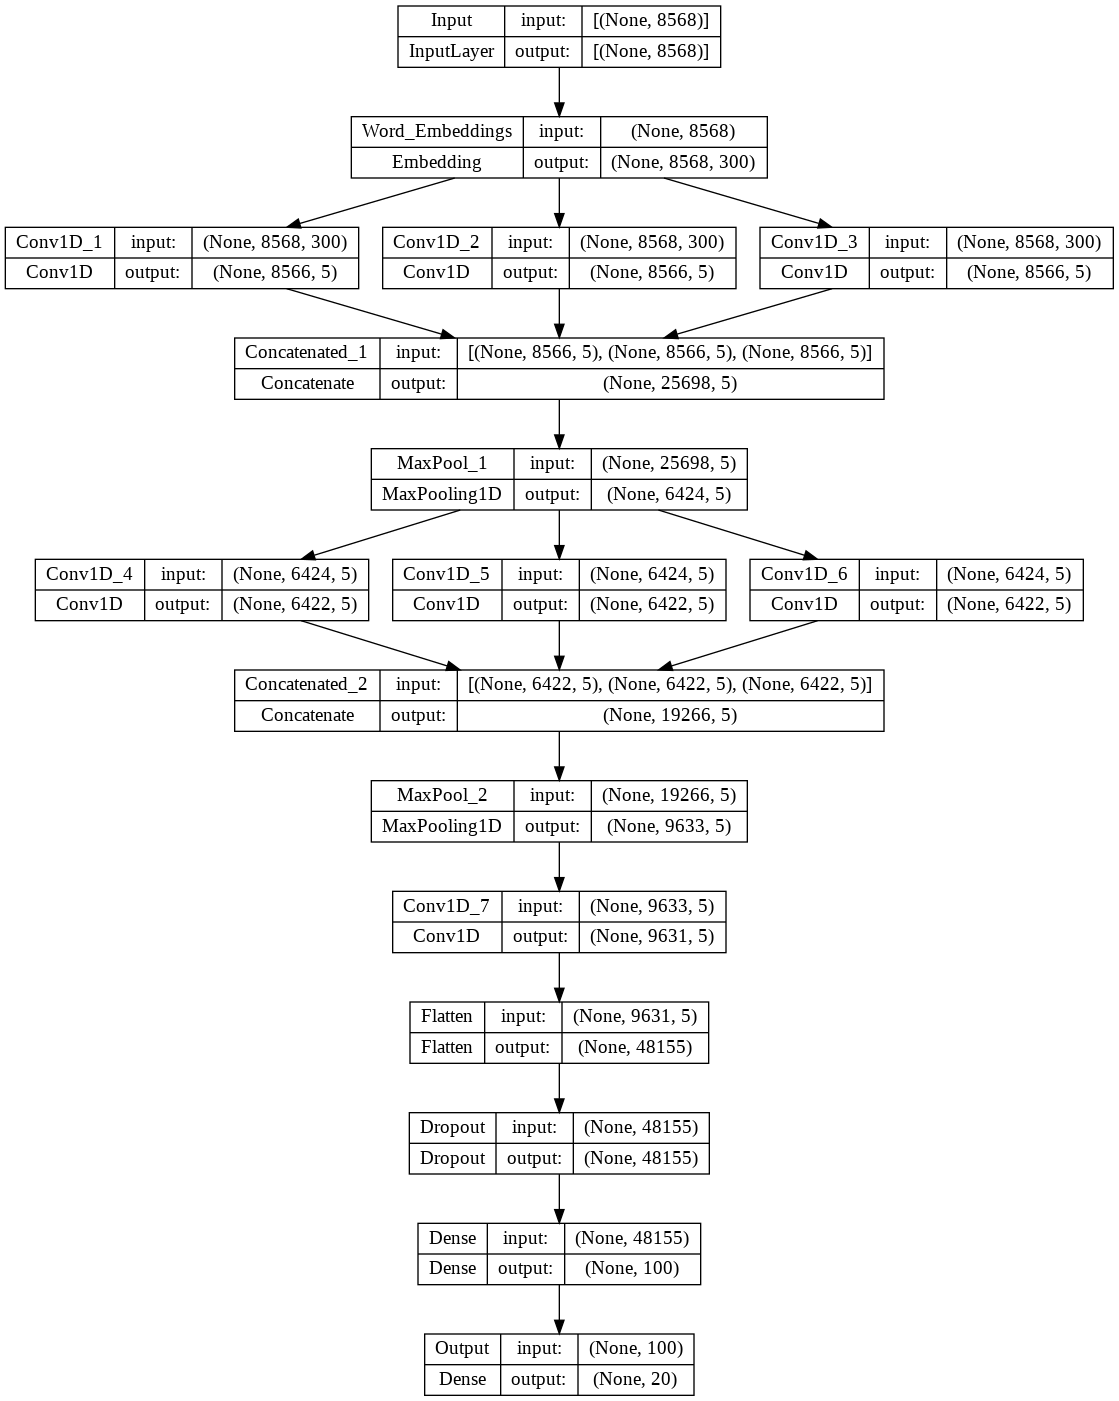

In [71]:
tf.keras.utils.plot_model(model=model_1,
                          to_file=os.path.join(base_path, 'model_1.png'),
                          show_shapes=True, 
                          show_layer_names=True,
                          expand_nested=False,
                          dpi=96)

In [72]:
train_loss_1, train_accuracy_1, _ = model_1.evaluate(x=X_train_padded_1, y=y_train_categorical)
print("Training Accuracy: {}.".format(train_accuracy_1 * 100))
print("Traning Loss: {}.".format(train_loss_1))

442/442 [==============================] - 14s 32ms/step - loss: 0.0367 - accuracy: 0.9921 - f1_score: 0.9921
Training Accuracy: 99.21393394470215.
Traning Loss: 0.03668484464287758.


In [73]:
test_loss_1, test_accuracy_1, _ = model_1.evaluate(x=X_test_padded_1, y=y_test_categorical)
print("Test Accuracy: {}.".format(test_accuracy_1 * 100))
print("Test Loss: {}.".format(test_loss_1))

148/148 [==============================] - 5s 32ms/step - loss: 2.5559 - accuracy: 0.6699 - f1_score: 0.6699
Test Accuracy: 66.98533892631531.
Test Loss: 2.5558791160583496.


Model 2

Here are the some papers based on Char-CNN

Here are the some papers based on Char-CNN
 1. Xiang Zhang, Junbo Zhao, Yann LeCun. <a href="http://arxiv.org/abs/1509.01626">Character-level Convolutional Networks for Text Classification</a>.NIPS 2015
 2. Yoon Kim, Yacine Jernite, David Sontag, Alexander M. Rush. <a href="https://arxiv.org/abs/1508.06615">Character-Aware Neural Language Models</a>. AAAI 2016
 3. Shaojie Bai, J. Zico Kolter, Vladlen Koltun. <a href="https://arxiv.org/pdf/1803.01271.pdf">An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling</a>
 4. Use the pratrained char embeddings <a href='https://github.com/minimaxir/char-embeddings/blob/master/glove.840B.300d-char.txt'>https://github.com/minimaxir/char-embeddings/blob/master/glove.840B.300d-char.txt</a>

![](https://i.imgur.com/EuuoJtr.png)

In [74]:
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [75]:
input_layer_2 = Input(shape=(maxlen_2, ), name='Input')

embedding_layer_2 = Embedding(input_dim=char_embedding_matrix.shape[0],
                              output_dim=char_embedding_matrix.shape[1],
                              weights=[char_embedding_matrix],
                              input_length=maxlen_2,
                              trainable=True,
                              name='Char_Embeddings')(input_layer_2)

conv1d1_2 = Conv1D(filters=5, kernel_size=3, kernel_initializer='he_normal', activation='relu', name='Conv1D_1')(embedding_layer_2)
conv1d2_2 = Conv1D(filters=5, kernel_size=3, kernel_initializer='he_normal', activation='relu', name='Conv1D_2')(conv1d1_2)

maxpool1_2 = MaxPooling1D(pool_size=4, name='MaxPool_1')(conv1d2_2)

conv1d3_2 = Conv1D(filters=5, kernel_size=3, kernel_initializer='he_normal', activation='relu', name='Conv1D_4')(maxpool1_2)
conv1d4_2 = Conv1D(filters=5, kernel_size=3, kernel_initializer='he_normal', activation='relu', name='Conv1D_5')(conv1d3_2)

maxpool2_2 = MaxPooling1D(pool_size=2, name='MaxPool_2')(conv1d4_2)

flat_2 = Flatten(name='Flatten')(maxpool2_2)

drop_2 = Dropout(rate=0.4, name='Dropout')(flat_2)

dense_2 = Dense(units=100, activation='relu', name='Dense')(drop_2)

output_layer_2 = Dense(units=num_classes, activation='softmax', name='Output')(dense_2)

In [76]:
model_2 = Model(inputs=input_layer_2, outputs=output_layer_2)
optimizer_2 = tf.keras.optimizers.Adam()
model_2.compile(optimizer=optimizer_2,
                loss='categorical_crossentropy',
                metrics=['accuracy', tfa.metrics.F1Score(num_classes=num_classes, average='micro')])

In [77]:
filepath_2 = "model_save/best_model_2.h5"
model_save_callback_2 = ModelCheckpoint(filepath=filepath_2, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

early_stop_callback_2 = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=2, verbose=1)

log_dir_2 = os.path.join('logs', 'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback_2 = TensorBoard(log_dir=log_dir_2, histogram_freq=1)

callbacks_2 = [model_save_callback_2, early_stop_callback_2, tensorboard_callback_2]

In [78]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 8000)]            0         
                                                                 
 Char_Embeddings (Embedding)  (None, 8000, 300)        13200     
                                                                 
 Conv1D_1 (Conv1D)           (None, 7998, 5)           4505      
                                                                 
 Conv1D_2 (Conv1D)           (None, 7996, 5)           80        
                                                                 
 MaxPool_1 (MaxPooling1D)    (None, 1999, 5)           0         
                                                                 
 Conv1D_4 (Conv1D)           (None, 1997, 5)           80        
                                                                 
 Conv1D_5 (Conv1D)           (None, 1995, 5)           80  

In [79]:
model_2.fit(x=X_train_padded_2,
            y=y_train_categorical,
            epochs=20,
            validation_data=(X_test_padded_2, y_test_categorical),
            batch_size=100,
            callbacks=callbacks_2)

Epoch 1/20
142/142 [==============================] - ETA: 0s - loss: 2.9481 - accuracy: 0.0772 - f1_score: 0.0772
Epoch 1: val_accuracy improved from -inf to 0.08753, saving model to model_save/best_model_2.h5
142/142 [==============================] - 21s 139ms/step - loss: 2.9481 - accuracy: 0.0772 - f1_score: 0.0772 - val_loss: 2.9241 - val_accuracy: 0.0875 - val_f1_score: 0.0875
Epoch 2/20
141/142 [============================>.] - ETA: 0s - loss: 2.9181 - accuracy: 0.0870 - f1_score: 0.0870
Epoch 2: val_accuracy improved from 0.08753 to 0.08965, saving model to model_save/best_model_2.h5
142/142 [==============================] - 20s 138ms/step - loss: 2.9183 - accuracy: 0.0870 - f1_score: 0.0870 - val_loss: 2.9172 - val_accuracy: 0.0897 - val_f1_score: 0.0897
Epoch 3/20
141/142 [============================>.] - ETA: 0s - loss: 2.8890 - accuracy: 0.1005 - f1_score: 0.1005
Epoch 3: val_accuracy did not improve from 0.08965
142/142 [==============================] - 20s 139ms/step

In [81]:
# %tensorboard --logdir logs/fits

Model 2 TensorBoard Images

![](https://user-images.githubusercontent.com/63338657/196056554-b1a9057e-687b-4013-88e3-6386ddc4301b.png)

![](https://user-images.githubusercontent.com/63338657/196056599-675440f5-515f-4d7d-99fa-6e7ac1d841c4.png)

![](https://user-images.githubusercontent.com/63338657/196056647-3d034ffd-3a3a-4546-9b03-9441b9b08de9.png)

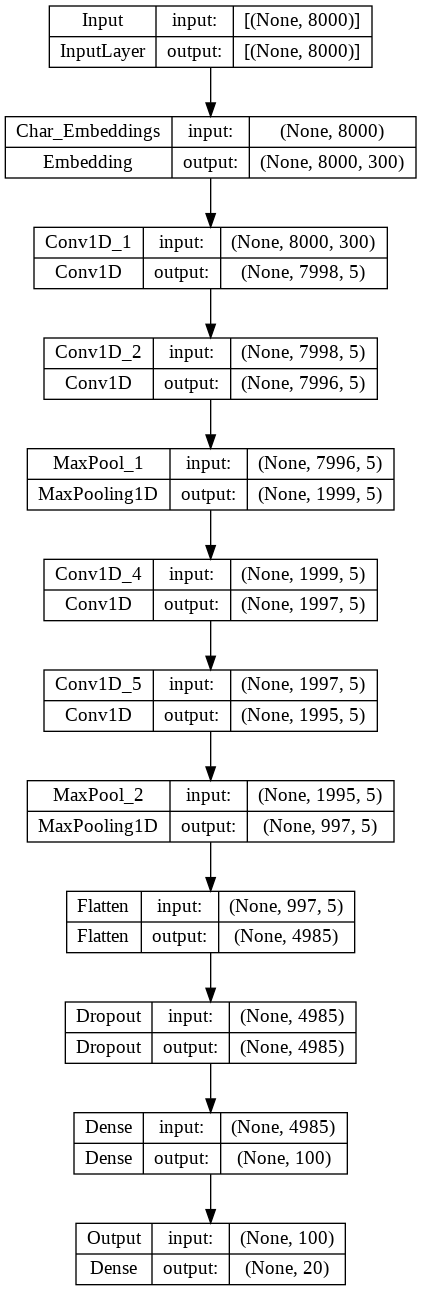

In [82]:
tf.keras.utils.plot_model(model=model_2,
                          to_file=os.path.join(base_path, 'model_2.png'),
                          show_shapes=True, 
                          show_layer_names=True,
                          expand_nested=False,
                          dpi=96)

In [83]:
train_loss_2, train_accuracy_2, _ = model_2.evaluate(x=X_train_padded_2, y=y_train_categorical)
print("Training Accuracy: {}.".format(train_accuracy_2 * 100))
print("Traning Loss: {}.".format(train_loss_2))

442/442 [==============================] - 5s 10ms/step - loss: 2.8248 - accuracy: 0.1299 - f1_score: 0.1299
Training Accuracy: 12.994830310344696.
Traning Loss: 2.8248414993286133.


In [84]:
test_loss_2, test_accuracy_2, _ = model_2.evaluate(x=X_test_padded_2, y=y_test_categorical)
print("Test Accuracy: {}.".format(test_accuracy_2 * 100))
print("Test Loss: {}.".format(test_loss_2))

148/148 [==============================] - 2s 11ms/step - loss: 2.9093 - accuracy: 0.0892 - f1_score: 0.0892
Test Accuracy: 8.92288088798523.
Test Loss: 2.9093451499938965.


End of the file.